Note:  
This notebook was executed on google colab pro.

In [ ]:
!pip3 install pytorch-lightning --quiet

     |████████████████████████████████| 813 kB 4.3 MB/s 
     |████████████████████████████████| 829 kB 36.3 MB/s 
     |████████████████████████████████| 118 kB 46.8 MB/s 
     |████████████████████████████████| 234 kB 46.3 MB/s 
     |████████████████████████████████| 636 kB 37.3 MB/s 
     |████████████████████████████████| 10.6 MB 53.2 MB/s 
     |████████████████████████████████| 1.3 MB 39.7 MB/s 
     |████████████████████████████████| 294 kB 40.8 MB/s 
     |████████████████████████████████| 142 kB 55.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [ ]:
EXP_NO = 14
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [ ]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [ ]:
MODEL_NAME = 'alexnet'
BATCH_SIZE = 128
NUM_EPOCHS = 50

# Library

In [ ]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [ ]:
pd.options.display.float_format = '{:.5f}'.format

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [ ]:
output_dir = experiment_dir_of(EXP_NO)

In [ ]:
output_dir

'../scripts/../experiments/exp014'

# Prepare logger

In [ ]:
logger = getLogger(__name__)

In [ ]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [ ]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-20 19:50:05,502 - __main__ - INFO - Experiment no: 14
2021-07-20 19:50:05,507 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-20 19:50:05,510 - __main__ - INFO - SEED: 1
2021-07-20 19:50:05,513 - __main__ - INFO - REGRESSION: True


# Load csv files

In [ ]:
SINCE = time.time()

In [ ]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-20 19:50:05,537 - __main__ - DEBUG - Start loading csv files (0.011 seconds passed)
2021-07-20 19:50:08,060 - __main__ - DEBUG - Complete loading csv files (2.534 seconds passed)


In [ ]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [ ]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [ ]:
seed_everything(SEED)

Global seed set to 1


1

In [ ]:
train.set_index('object_id', inplace=True)

2021-07-20 19:50:08,844 - __main__ - DEBUG - Start fold 1 (3.318 seconds passed)
2021-07-20 19:50:08,853 - __main__ - DEBUG - Start training model (3.328 seconds passed)
2021-07-20 19:50:15,737 - __main__ - DEBUG - Epoch 0/49
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2021-07-20 20:04:01,305 - __main__ - DEBUG - train Loss: 275.4305
2021-07-20 20:07:23,615 - __main__ - DEBUG - val Loss: 1.2836
2021-07-20 20:07:23,622 - __main__ - DEBUG - Epoch 1/49
2021-07-20 20:07:35,626 - __main__ - DEBUG - train Loss: 1.1815
2021-07-20 20:07:39,128 - __main__ - DEBUG - val Loss: 1.1826
2021-07-20 20:07:39,134 - __main__ - DEBUG - Epoch 2/49
2021

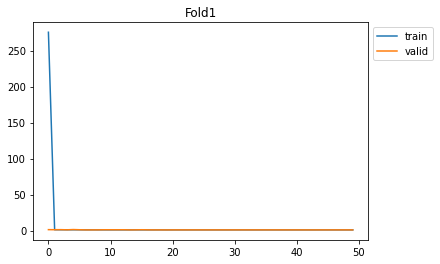

2021-07-20 20:43:51,610 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp014/cv_fold1_training.csv (3226.085 seconds passed)
2021-07-20 20:43:51,626 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp014/cv_fold1_validation.csv (3226.100 seconds passed)
2021-07-20 20:43:51,653 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp014/cv_fold1_test.csv (3226.127 seconds passed)
2021-07-20 20:43:52,658 - __main__ - DEBUG - Save model ../scripts/../experiments/exp014/cv_fold1_model.torch (3227.132 seconds passed)
2021-07-20 20:43:52,746 - __main__ - DEBUG - Complete fold 1 (3227.220 seconds passed)
2021-07-20 20:43:52,752 - __main__ - DEBUG - Start fold 2 (3227.226 seconds passed)
2021-07-20 20:43:52,761 - __main__ - DEBUG - Start training model (3227.235 seconds passed)
2021-07-20 20:43:53,309 - __main__ - DEBUG - Epoch 0/49
2021-07-20 20:44:06,123 - __main__ - DEBUG - train Loss: 350.6566
2021-07-20 20:44:09,527 - __main__ - DEB

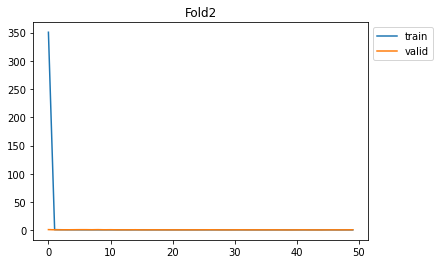

2021-07-20 20:57:12,743 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp014/cv_fold2_training.csv (4027.217 seconds passed)
2021-07-20 20:57:12,758 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp014/cv_fold2_validation.csv (4027.232 seconds passed)
2021-07-20 20:57:12,784 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp014/cv_fold2_test.csv (4027.258 seconds passed)
2021-07-20 20:57:13,722 - __main__ - DEBUG - Save model ../scripts/../experiments/exp014/cv_fold2_model.torch (4028.196 seconds passed)
2021-07-20 20:57:13,812 - __main__ - DEBUG - Complete fold 2 (4028.286 seconds passed)
2021-07-20 20:57:13,817 - __main__ - DEBUG - Start fold 3 (4028.291 seconds passed)
2021-07-20 20:57:13,827 - __main__ - DEBUG - Start training model (4028.302 seconds passed)
2021-07-20 20:57:14,353 - __main__ - DEBUG - Epoch 0/49
2021-07-20 20:57:26,277 - __main__ - DEBUG - train Loss: 152.6854
2021-07-20 20:57:29,665 - __main__ - DEB

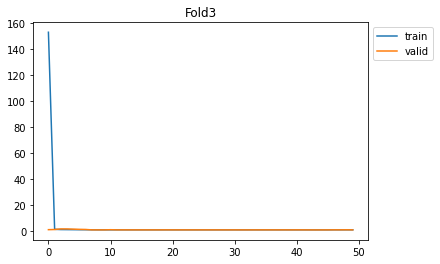

2021-07-20 21:10:18,185 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp014/cv_fold3_training.csv (4812.660 seconds passed)
2021-07-20 21:10:18,201 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp014/cv_fold3_validation.csv (4812.676 seconds passed)
2021-07-20 21:10:18,230 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp014/cv_fold3_test.csv (4812.704 seconds passed)
2021-07-20 21:10:19,109 - __main__ - DEBUG - Save model ../scripts/../experiments/exp014/cv_fold3_model.torch (4813.583 seconds passed)
2021-07-20 21:10:19,206 - __main__ - DEBUG - Complete fold 3 (4813.680 seconds passed)
2021-07-20 21:10:19,214 - __main__ - DEBUG - Start fold 4 (4813.688 seconds passed)
2021-07-20 21:10:19,243 - __main__ - DEBUG - Start training model (4813.718 seconds passed)
2021-07-20 21:10:19,758 - __main__ - DEBUG - Epoch 0/49
2021-07-20 21:10:32,513 - __main__ - DEBUG - train Loss: 80.0823
2021-07-20 21:10:35,849 - __main__ - DEBU

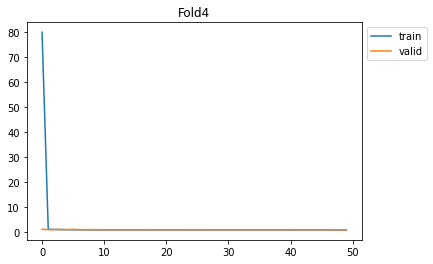

2021-07-20 21:23:33,864 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp014/cv_fold4_training.csv (5608.339 seconds passed)
2021-07-20 21:23:33,882 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp014/cv_fold4_validation.csv (5608.356 seconds passed)
2021-07-20 21:23:33,911 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp014/cv_fold4_test.csv (5608.385 seconds passed)
2021-07-20 21:23:34,844 - __main__ - DEBUG - Save model ../scripts/../experiments/exp014/cv_fold4_model.torch (5609.318 seconds passed)
2021-07-20 21:23:34,945 - __main__ - DEBUG - Complete fold 4 (5609.419 seconds passed)
2021-07-20 21:23:34,954 - __main__ - DEBUG - Start fold 5 (5609.428 seconds passed)
2021-07-20 21:23:34,971 - __main__ - DEBUG - Start training model (5609.445 seconds passed)
2021-07-20 21:23:35,537 - __main__ - DEBUG - Epoch 0/49
2021-07-20 21:23:48,354 - __main__ - DEBUG - train Loss: 96.6371
2021-07-20 21:23:51,845 - __main__ - DEBU

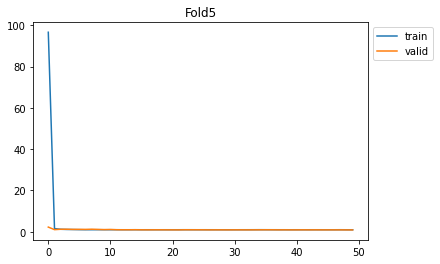

2021-07-20 21:37:03,848 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp014/cv_fold5_training.csv (6418.322 seconds passed)
2021-07-20 21:37:03,865 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp014/cv_fold5_validation.csv (6418.339 seconds passed)
2021-07-20 21:37:03,896 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp014/cv_fold5_test.csv (6418.370 seconds passed)
2021-07-20 21:37:04,811 - __main__ - DEBUG - Save model ../scripts/../experiments/exp014/cv_fold5_model.torch (6419.285 seconds passed)
2021-07-20 21:37:04,911 - __main__ - DEBUG - Complete fold 5 (6419.386 seconds passed)


In [ ]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    model, input_size = initialize_model(MODEL_NAME)
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.MSELoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        predictions = {}
        for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                     [train_object_ids, valid_object_ids, test['object_id']]):
            # Prepare transformer
            transformer_ = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            # Prepare dataset
            dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
            # Prepare dataloader
            dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                     num_workers=os.cpu_count())
            # Prediction
            predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:  # Do not come here!
        raise NotImplemented
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [ ]:
rmse = partial(mean_squared_error, squared=False)

In [ ]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [ ]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [ ]:
metrics = defaultdict(list)

## Training set

In [ ]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-20 21:37:05,016 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-20 21:37:05,048 - __main__ - DEBUG - Loss: 0.9500809249264514
2021-07-20 21:37:05,050 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-20 21:37:05,066 - __main__ - DEBUG - Loss: 0.9160262476995336
2021-07-20 21:37:05,068 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-20 21:37:05,086 - __main__ - DEBUG - Loss: 0.9424447238517912
2021-07-20 21:37:05,091 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-20 21:37:05,105 - __main__ - DEBUG - Loss: 0.9455236179621171
2021-07-20 21:37:05,109 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-20 21:37:05,125 - __main__ - DEBUG - Loss: 0.9516339300457386


In [ ]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.44531,1
00309fb1ef05416f9c1f,1.54939,3
003a1562e97f79ba96dc,1.43782,3
004890880e8e7431147b,1.34272,2
00718c32602425f504c1,1.42751,3
...,...,...
ffa3259fff8e6f3818a1,1.41563,3
ffd4d361756587883e48,1.23839,1
ffd794b7b311b7b7fd92,1.54809,2


In [ ]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-20 21:37:05,198 - __main__ - INFO - Training loss: 1.0170390280386037


In [ ]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-20 21:37:05,233 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp014/prediction_train.csv


## Validation set

In [ ]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-20 21:37:05,266 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-20 21:37:05,280 - __main__ - DEBUG - Loss: 0.9540455591315248
2021-07-20 21:37:05,282 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-20 21:37:05,295 - __main__ - DEBUG - Loss: 0.9227378831157992
2021-07-20 21:37:05,296 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-20 21:37:05,309 - __main__ - DEBUG - Loss: 0.9402120668182802
2021-07-20 21:37:05,310 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-20 21:37:05,329 - __main__ - DEBUG - Loss: 0.9808716612514283
2021-07-20 21:37:05,331 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-20 21:37:05,344 - __main__ - DEBUG - Loss: 0.9258167315159808


In [ ]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.28767,1
00309fb1ef05416f9c1f,0.37493,3
003a1562e97f79ba96dc,0.39311,3
004890880e8e7431147b,0.34251,2
00718c32602425f504c1,0.35484,3
...,...,...
ffa3259fff8e6f3818a1,0.38269,3
ffd4d361756587883e48,0.34328,1
ffd794b7b311b7b7fd92,0.37009,2


In [ ]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-20 21:37:05,406 - __main__ - INFO - Validatino loss: 1.7374092586382408


In [ ]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-20 21:37:05,448 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp014/prediction_valid.csv


In [ ]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-20 21:37:05,469 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp014/metrics.json


# Prediction

In [ ]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [ ]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.71342
000bd5e82eb22f199f44,1.91172
0015f44de1854f617516,1.73373
00388a678879ba1efa27,1.84600
005e1e7c6496902d23f3,1.55471
...,...
ffbe65ad399b632dcbd0,1.77801
ffd7b2d646c0320c311a,1.64001
ffdb93ede17d4501e530,1.74968


In [ ]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.71342
1,1.91172
2,1.73373
3,1.84600
4,1.55471
...,...
5914,1.77801
5915,1.64001
5916,1.74968
5917,1.64819


In [ ]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [ ]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-20 21:37:05,652 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp014/014_submission.csv


2021-07-20 21:37:05,872 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp014/prediction.png


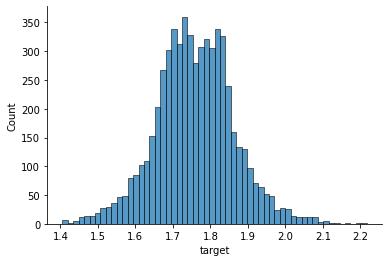

In [ ]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [ ]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-20 21:37:06,170 - __main__ - DEBUG - Complete (6420.644 seconds passed)
